In [309]:

#import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from venny4py.venny4py import *
import pickle
import shap
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

### Read the dataset

In [310]:
df1 = pd.read_excel(r'Amide-Pos-final.xlsx')
df2 = pd.read_excel(r'Amide-Neg-final.xlsx')
df3 = pd.read_excel(r'T3-Pos-final.xlsx')
df4 = pd.read_excel(r'T3-Neg-final.xlsx')

In [311]:
# df1 = pd.read_excel(r'Amide-Pos-one.xlsx')
# df2 = pd.read_excel(r'Amide-Neg-one.xlsx')
# df3 = pd.read_excel(r'T3-Pos-one.xlsx')
# df4 = pd.read_excel(r'T3-Neg-one.xlsx')

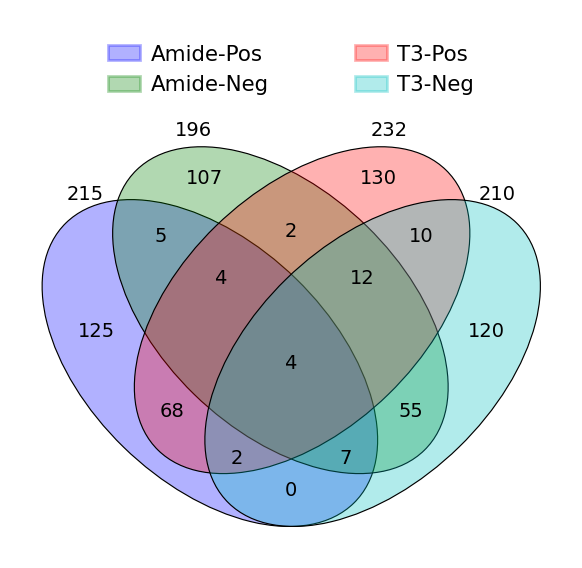

In [312]:
# Make the Venn diagram
set1 = set(df1['Name'])
set2 = set(df2['Name'])
set3 = set(df3['Name'])
set4 = set(df4['Name'])
sets = {
    'Amide-Pos':set1,
    'Amide-Neg':set2,
    'T3-Pos':set3,
    'T3-Neg':set4
}
venny4py(sets=sets)


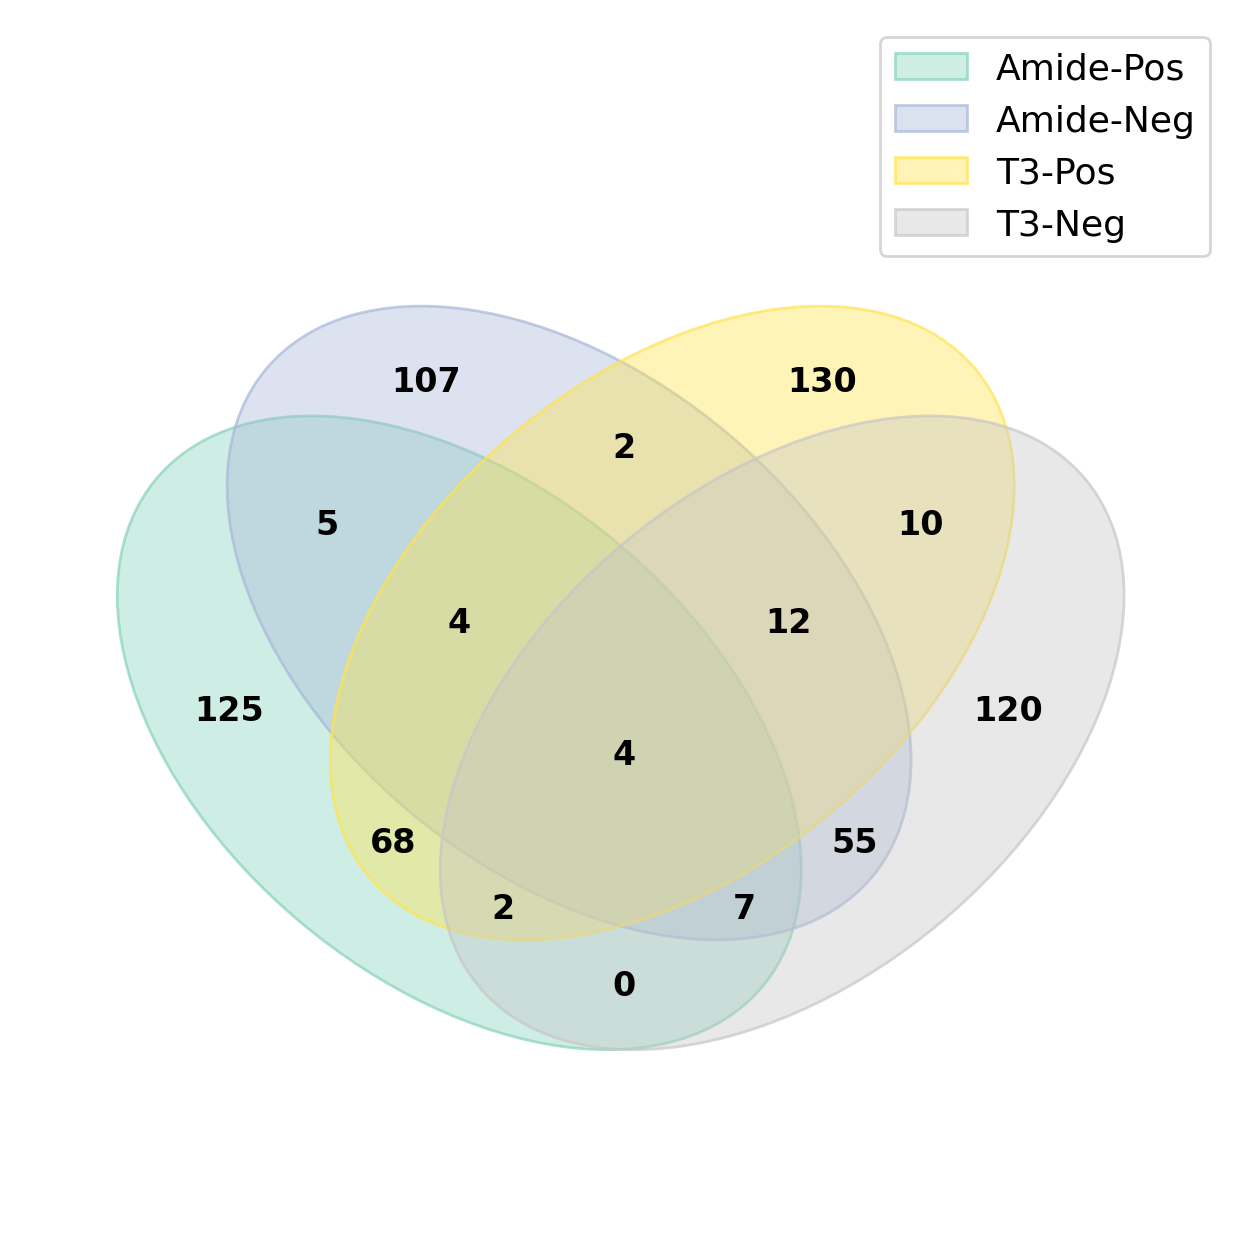

In [134]:
from venn import venn
from matplotlib import colors

set1 = set(df1['Name'])
set2 = set(df2['Name'])
set3 = set(df3['Name'])
set4 = set(df4['Name'])

# Define the sets
venn_data = {
    "Amide-Pos": set1,
    "Amide-Neg": set2,
    "T3-Pos": set3,
    "T3-Neg": set4
}

# Create a darker version of the Set2 colormap
cmap = plt.get_cmap('Set2')
dark_cmap = colors.LinearSegmentedColormap.from_list("dark_Set2", cmap(np.linspace(0, 1, 4))**0.7)

# Create the Venn diagram with the darker colormap
venn(venn_data, cmap=dark_cmap)

# Loop through all the text objects in the plot and update their properties
for text in plt.gca().texts:
    text.set_color('black')  # Change color
    text.set_fontsize(12)    # Change font size
    text.set_fontweight('bold')  # Change font weight

# Save and display the plot
#plt.savefig('venn_updated.png', dpi=300, bbox_inches='tight')
plt.show()

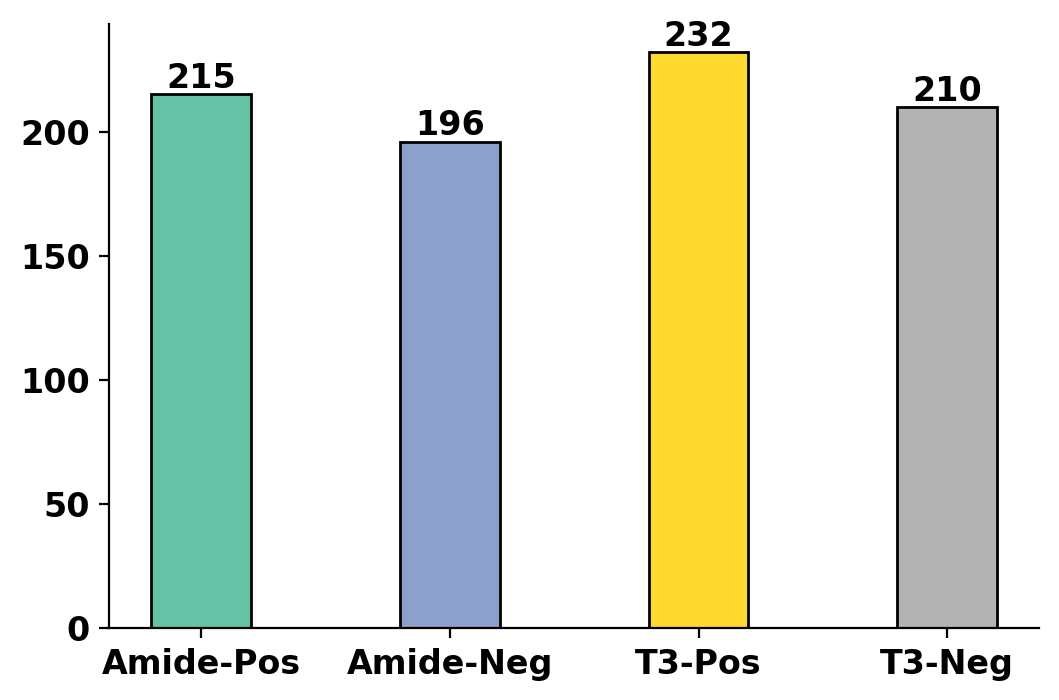

In [131]:
# Get the sizes of each set
sizes = {
    'Amide-Pos': len(set1),
    'Amide-Neg': len(set2),
    'T3-Pos': len(set3),
    'T3-Neg': len(set4)
}

# Create a colormap
cmap = plt.get_cmap('Set2')
colors = cmap(np.linspace(0, 1, 4))

fig, ax = plt.subplots()

# Create the bar plot with smaller bars
bars = ax.bar(sizes.keys(), sizes.values(), color=colors, edgecolor='black', width=0.4)

# Hide the right and top spines (axes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()

# Add text annotations on the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom',fontsize=12,weight='bold')

##plt.xlabel('Set', fontsize=14)
##plt.ylabel('Size', fontsize=14)
#plt.title('Size of Each Set', fontsize=16)
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')
#plt.grid(axis='y')
# Save the plot as a high-resolution PNG file
plt.savefig('bar.png', dpi=300, bbox_inches='tight')
plt.show()

### Pathway analysis

In [ ]:
import scipy.stats as stats

# Assume df is your DataFrame and 'Status' is your target column
significant_metabolites = []
for metabolite in df.columns[:-1]:
    healthy = df[df['Status'] == 'healthy'][metabolite]
    disease = df[df['Status'] == 'disease'][metabolite]

    # Using t-test here, but you might want to use non-parametric tests like Mann-Whitney 
    # if your data is not normally distributed
    t_stat, p_val = stats.ttest_ind(healthy, disease)

    if p_val < 0.05:  # or your desired significance level
        significant_metabolites.append(metabolite)

### Data Cleaning

#### Extract the relevant columns from the dataframe

In [313]:
#Drop the duplicates in the column of 'Name' and combine the 4 columns
df1 = df1.drop_duplicates(subset='Name', keep='first')
df2 = df2.drop_duplicates(subset='Name', keep='first')
df3 = df3.drop_duplicates(subset='Name', keep='first')
df4 = df4.drop_duplicates(subset='Name', keep='first')



In [314]:
#Change the columns name of feature in df1
column_mapping={ 
       'Area: ZAW-19102023-T3-POS-Cal3.raw (F23)':'Cal3',
       'Area: ZAW-19102023-T3-POS-Cal5.raw (F24)':'Cal5',
       'Area: ZAW-18102023-AMIDE-POS-H2.raw (F1)':'H2',
       'Area: ZAW-18102023-AMIDE-POS-H3.raw (F2)':'H3',
       'Area: ZAW-18102023-AMIDE-POS-H5.raw (F3)':'H5',
       'Area: ZAW-18102023-AMIDE-POS-H8.raw (F4)':'H8',
       'Area: ZAW-18102023-AMIDE-POS-H11.raw (F6)':'H11',
       'Area: ZAW-18102023-AMIDE-POS-H12.raw (F7)':'H12',
       'Area: ZAW-18102023-AMIDE-POS-H14.raw (F8)':'H14',
       'Area: ZAW-18102023-AMIDE-POS-H15.raw (F9)':'H15',
       'Area: ZAW-18102023-AMIDE-POS-QC.raw (F10)':'QC',
       'Area: ZAW-18102023-AMIDE-POS-QC_20231018210935.raw (F11)':'QC1',
       'Area: ZAW-18102023-AMIDE-POS-QC_20231018212617.raw (F12)':'QC2',
       'Area: ZAW-18102023-AMIDE-POS-QC_20231018214300.raw (F13)':'QC3',
       'Area: ZAW-18102023-AMIDE-POS-QC_20231018221624.raw (F14)':'QC4',
       'Area: ZAW-18102023-AMIDE-POS-QC_20231019004629.raw (F15)':'QC5',
       'Area: ZAW-18102023-AMIDE-POS-R2.raw (F16)':'R2',
       'Area: ZAW-18102023-AMIDE-POS-R3.raw (F17)':'R3',
       'Area: ZAW-18102023-AMIDE-POS-R9.raw (F19)':'R9',
       'Area: ZAW-18102023-AMIDE-POS-R10.raw (F20)':'R10',
       'Area: ZAW-18102023-AMIDE-POS-R13.raw (F21)':'R13',
       'Area: ZAW-18102023-AMIDE-POS-R14.raw (F22)':'R14'}

df1 = df1.rename(columns=column_mapping)

In [315]:
#Change the columns name of feature in df2
column_mapping = {
       'Area: ZAW-19102023-T3-NEG-Cal3.raw (F86)':'Cal3',
       'Area: ZAW-19102023-T3-NEG-Cal5.raw (F87)':'Cal5',
       'Area: ZAW-18102023-AMIDE-NEG-H2.raw (F64)':'H2',
       'Area: ZAW-18102023-AMIDE-NEG-H3.raw (F65)':'H3',
       'Area: ZAW-18102023-AMIDE-NEG-H5.raw (F66)':'H5',
       'Area: ZAW-18102023-AMIDE-NEG-H8.raw (F67)':'H8',
       'Area: ZAW-18102023-AMIDE-NEG-H11.raw (F69)':'H11',
       'Area: ZAW-18102023-AMIDE-NEG-H12.raw (F70)':'H12',
       'Area: ZAW-18102023-AMIDE-NEG-H14.raw (F71)':'H14',
       'Area: ZAW-18102023-AMIDE-NEG-H15.raw (F72)':'H15',
       'Area: ZAW-18102023-AMIDE-NEG-QC.raw (F73)':'QC',
       'Area: ZAW-18102023-AMIDE-NEG-QC_20231019060710.raw (F74)':'QC1',
       'Area: ZAW-18102023-AMIDE-NEG-QC_20231019062352.raw (F75)':'QC2',
       'Area: ZAW-18102023-AMIDE-NEG-QC_20231019064034.raw (F76)':'QC3',
       'Area: ZAW-18102023-AMIDE-NEG-QC_20231019071359.raw (F77)':'QC4',
       'Area: ZAW-18102023-AMIDE-NEG-QC_20231019094359.raw (F78)':'QC5',
       'Area: ZAW-18102023-AMIDE-NEG-R2.raw (F79)':'R2',
       'Area: ZAW-18102023-AMIDE-NEG-R3.raw (F80)':'R3',
       'Area: ZAW-18102023-AMIDE-NEG-R9.raw (F82)':'R9',
       'Area: ZAW-18102023-AMIDE-NEG-R10.raw (F83)':'R10',
       'Area: ZAW-18102023-AMIDE-NEG-R13.raw (F84)':'R13',
       'Area: ZAW-18102023-AMIDE-NEG-R14.raw (F85)':'R14',  
}
df2 = df2.rename(columns=column_mapping)

In [316]:
#Change the columns name of feature in df3
column_mapping = {
       'Area: ZAW-19102023-T3-POS-Cal3.raw (F35)':'Cal3',
       'Area: ZAW-19102023-T3-POS-Cal5.raw (F36)':'Cal5',
       'Area: ZAW-19102023-T3-POS-H2.raw (F37)':'H2',
       'Area: ZAW-19102023-T3-POS-H3.raw (F38)':'H3',
       'Area: ZAW-19102023-T3-POS-H5.raw (F39)':'H5',
       'Area: ZAW-19102023-T3-POS-H8.raw (F40)':'H8',
       'Area: ZAW-19102023-T3-POS-H11.raw (F42)':'H11',
       'Area: ZAW-19102023-T3-POS-H12.raw (F43)':'H12',
       'Area: ZAW-19102023-T3-POS-H14.raw (F44)':'H14',
       'Area: ZAW-19102023-T3-POS-H15.raw (F45)':'H15',
       'Area: ZAW-19102023-T3-POS-QC.raw (F46)':'QC',
       'Area: ZAW-19102023-T3-POS-QC_20231019185615.raw (F47)':'QC1',
       'Area: ZAW-19102023-T3-POS-QC_20231019191257.raw (F48)':'QC2',
       'Area: ZAW-19102023-T3-POS-QC_20231019192939.raw (F49)':'QC3',
       'Area: ZAW-19102023-T3-POS-QC_20231019200304.raw (F50)':'QC4',
       'Area: ZAW-19102023-T3-POS-QC_20231019223307.raw (F51)':'QC5',
       'Area: ZAW-19102023-T3-POS-R2.raw (F52)':'R2',
       'Area: ZAW-19102023-T3-POS-R3.raw (F53)':'R3',
       'Area: ZAW-19102023-T3-POS-R9.raw (F55)':'R9',
       'Area: ZAW-19102023-T3-POS-R10.raw (F56)':'R10',
       'Area: ZAW-19102023-T3-POS-R13.raw (F57)':'R13',
       'Area: ZAW-19102023-T3-POS-R14.raw (F58)':'R14', 
}
df3 = df3.rename(columns=column_mapping)

In [317]:
#Change the columns name of feature in df4
column_mapping = {
       'Area: ZAW-19102023-T3-NEG-Cal3.raw (F115)':'Cal3',
       'Area: ZAW-19102023-T3-NEG-Cal5.raw (F116)':'Cal5',
       'Area: ZAW-18102023-T3-NEG-H2.raw (F93)':'H2',
       'Area: ZAW-18102023-T3-NEG-H3.raw (F94)':'H3',
       'Area: ZAW-18102023-T3-NEG-H5.raw (F95)':'H5',
       'Area: ZAW-18102023-T3-NEG-H8.raw (F96)':'H8',
       'Area: ZAW-18102023-T3-NEG-H11.raw (F98)':'H11',
       'Area: ZAW-18102023-T3-NEG-H12.raw (F99)':'H12',
       'Area: ZAW-18102023-T3-NEG-H14.raw (F100)':'H14',
       'Area: ZAW-18102023-T3-NEG-H15.raw (F101)':'H15',
       'Area: ZAW-18102023-T3-NEG-QC.raw (F102)':'QC',
       'Area: ZAW-18102023-T3-NEG-QC_20231020044408.raw (F103)':'QC1',
       'Area: ZAW-18102023-T3-NEG-QC_20231020050050.raw (F104)':'QC2',
       'Area: ZAW-18102023-T3-NEG-QC_20231020051733.raw (F105)':'QC3',
       'Area: ZAW-18102023-T3-NEG-QC_20231020055057.raw (F106)':'QC4',
       'Area: ZAW-18102023-T3-NEG-QC_20231020082058.raw (F107)':'QC5',
       'Area: ZAW-18102023-T3-NEG-R2.raw (F108)':'R2',
       'Area: ZAW-18102023-T3-NEG-R3.raw (F109)':'R3',
       'Area: ZAW-18102023-T3-NEG-R9.raw (F111)':'R9',
       'Area: ZAW-18102023-T3-NEG-R10.raw (F112)':'R10',
       'Area: ZAW-18102023-T3-NEG-R13.raw (F113)':'R13',
       'Area: ZAW-18102023-T3-NEG-R14.raw (F114)':'R14',
}
df4 = df4.rename(columns=column_mapping)

In [318]:
# combine 4 columns 
df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)

In [319]:
column = [
     'Name', 'Formula','Area (Max.)', 'H2', 'H3', 'H5', 'H8', 'H11', 'H12', 'H14', 'H15','R2', 'R3', 'R9', 'R10', 'R13','R14'
]
df=df[column]

In [320]:
# Sort by number of 'Area (Max.)' column
df = df.sort_values('Area (Max.)', ascending=False)

# drop the the duplicate base on 'Name' and leave the highest one of 'Area (Max.)'
df= df.drop_duplicates(subset='Name', keep='first')
len(df['Name'])



651

In [321]:
#transpose the DataFrame 
df = df.set_index('Name').T

In [322]:
#drop 'Formula'and 'Area(Max.)'rows
df = df.drop(df.index[0:2])

In [323]:
#Rename the 'Name' column to 'SampleID'
df = df.rename_axis('SampleID', axis='columns')

In [324]:
# add class column for classification
df['Class'] = df.index.map(lambda x: 'H' if x.startswith('H') else 'R')


In [326]:
df

SampleID,L-Iditol,L(-)-Carnitine,L-Isoleucine,L-Kynurenine,Creatinine,Betaine,3-Methylhistidine,"2-Hydroxy-3-[(9Z,12Z)-9,12-octadecadienoyloxy]propyl 2-(trimethylammonio)ethyl phosphate",5-Hydroxyindole-3-acetic acid,Acetyl-L-carnitine,...,AM9627000,"N,N-Dimethyldecylamine N-oxide",[Similar to: NP-014789; ΔMass: 0.0002 Da],[Similar to: NP-014789; ΔMass: 0.0003 Da],[Similar to: Deoxycholic acid; ΔMass: 0.7034 Da],Aceglutamide,"[Similar to: N-(2-morpholinophenyl)-2,1,3-benzoxadiazole-4-sulfonamide; ΔMass: 0.0351 Da]",[Similar to: N-Acetylneuraminic acid; ΔMass: -0.1281 Da],[Similar to: (±)9-HpODE; ΔMass: -0.0979 Da],Class
H2,158872.195838,1342810837.85585,586851282.882509,6020632.734513,693603174.780366,871425465.490798,4850335.999439,1363075637.39559,2563461.364926,432978072.991588,...,99700.703169,33924.378736,13405.944505,13405.944505,3217.484965,3233.317368,2102.747728,39672.375037,4709.298789,H
H3,124262.388143,38465360.086006,601281333.140827,8389793.214612,25954926.360688,711181565.79392,5025324.398499,1081221707.26218,3665738.797952,4226191.366357,...,61309.568003,43795.368554,16770.295181,4732.767331,3318.705028,3814.49674,1843.489645,12055.538471,4575.176927,H
H5,785580.647269,3217805633.92917,753389880.604009,8154283.300603,1445161870.33234,1625273038.08144,2225163.42291,1068991632.05025,3512285.184935,506325925.725981,...,80886.432163,35325.246959,33856.54316,30338.892929,135014.568271,69226.775189,14778.639016,27160.639936,31985.881606,H
H8,2838781.557358,2971619070.36085,623224650.548959,10330596.871105,1767293873.44029,2114781453.54984,2471315.731614,1122122060.5089,4488139.600605,761005685.830629,...,118266.141846,32009.82634,3085.078743,4756.850364,98897.087085,91643.050758,15027.321477,24355.701081,33741.058442,H
H11,1626351.990806,3917611769.20386,849258122.526148,12628082.741633,2765260713.56529,1309143627.27538,5219548.226943,663838185.523798,5575500.983194,1348952575.9475,...,24291.59008,32709.383426,3365.638941,3137.371762,166232.916467,162753.789025,20221.73515,16035.532942,31827.217739,H
H12,1389976.823745,3758603370.67093,967479195.058075,14454012.125494,2069965278.86549,1666893192.26314,5449829.208043,855340318.443454,6304712.89051,788361598.812348,...,30075.811624,21871.300492,3102.46946,4597.080754,121874.130761,71134.075964,124166.78441,43214.607127,35086.234028,H
H14,14920393.649927,3230919414.36694,1000958918.75464,9059267.454083,1799626068.87977,1789627038.44997,3954422.448023,1801001651.00866,3867692.525988,552426878.751664,...,54318.63065,35100.07339,3050.66563,4838.839796,65604.276544,72524.917519,46740.882728,29225.67466,35521.519964,H
H15,837144.402003,2940245848.21787,846079794.672001,7594176.195818,1697603242.00364,1828714114.71182,4895814.152163,1500159072.60504,3236430.054708,564261547.817333,...,33747.004185,30590.433115,3022.425226,4759.945466,55151.008758,70498.184028,9662.280633,41697.431391,41395.616244,H
R2,723626.665177,3319347056.98942,809929827.790111,8329400.428548,1853014203.91018,1800209490.7528,2453389.261953,1519786736.66157,3529201.82713,1074213070.46056,...,95101.022541,37085.890196,3059.68114,4667.812179,103938.675753,115299.960251,11446.98782,32783.138515,32538.590829,R
R3,34591725.246441,1168551380.82593,989883469.547434,15973045.795184,761657568.184079,815031173.914652,4949077.672128,1497526981.82962,6882325.430484,163308888.687681,...,165874.028081,35893.264879,3079.82627,4627.46006,117207.341591,128839.225717,6231.193603,33372.065722,24982.767259,R


### Check NaN values

In [295]:
if df.isna().any().any():
    print('Yes')
else:
    print('No')
    

No


In [296]:
# Rseset index
df.reset_index(drop=True, inplace=True)

In [297]:
df

SampleID,L-Iditol,L(-)-Carnitine,L-Isoleucine,L-Kynurenine,Creatinine,Betaine,3-Methylhistidine,"2-Hydroxy-3-[(9Z,12Z)-9,12-octadecadienoyloxy]propyl 2-(trimethylammonio)ethyl phosphate",5-Hydroxyindole-3-acetic acid,Acetyl-L-carnitine,...,AM9627000,"N,N-Dimethyldecylamine N-oxide",[Similar to: NP-014789; ΔMass: 0.0002 Da],[Similar to: NP-014789; ΔMass: 0.0003 Da],[Similar to: Deoxycholic acid; ΔMass: 0.7034 Da],Aceglutamide,"[Similar to: N-(2-morpholinophenyl)-2,1,3-benzoxadiazole-4-sulfonamide; ΔMass: 0.0351 Da]",[Similar to: N-Acetylneuraminic acid; ΔMass: -0.1281 Da],[Similar to: (±)9-HpODE; ΔMass: -0.0979 Da],Class
0,158872.195838,1342810837.85585,586851282.882509,6020632.734513,693603174.780366,871425465.490798,4850335.999439,1363075637.39559,2563461.364926,432978072.991588,...,99700.703169,33924.378736,13405.944505,13405.944505,3217.484965,3233.317368,2102.747728,39672.375037,4709.298789,H
1,124262.388143,38465360.086006,601281333.140827,8389793.214612,25954926.360688,711181565.79392,5025324.398499,1081221707.26218,3665738.797952,4226191.366357,...,61309.568003,43795.368554,16770.295181,4732.767331,3318.705028,3814.49674,1843.489645,12055.538471,4575.176927,H
2,785580.647269,3217805633.92917,753389880.604009,8154283.300603,1445161870.33234,1625273038.08144,2225163.42291,1068991632.05025,3512285.184935,506325925.725981,...,80886.432163,35325.246959,33856.54316,30338.892929,135014.568271,69226.775189,14778.639016,27160.639936,31985.881606,H
3,2838781.557358,2971619070.36085,623224650.548959,10330596.871105,1767293873.44029,2114781453.54984,2471315.731614,1122122060.5089,4488139.600605,761005685.830629,...,118266.141846,32009.82634,3085.078743,4756.850364,98897.087085,91643.050758,15027.321477,24355.701081,33741.058442,H
4,1626351.990806,3917611769.20386,849258122.526148,12628082.741633,2765260713.56529,1309143627.27538,5219548.226943,663838185.523798,5575500.983194,1348952575.9475,...,24291.59008,32709.383426,3365.638941,3137.371762,166232.916467,162753.789025,20221.73515,16035.532942,31827.217739,H
5,1389976.823745,3758603370.67093,967479195.058075,14454012.125494,2069965278.86549,1666893192.26314,5449829.208043,855340318.443454,6304712.89051,788361598.812348,...,30075.811624,21871.300492,3102.46946,4597.080754,121874.130761,71134.075964,124166.78441,43214.607127,35086.234028,H
6,14920393.649927,3230919414.36694,1000958918.75464,9059267.454083,1799626068.87977,1789627038.44997,3954422.448023,1801001651.00866,3867692.525988,552426878.751664,...,54318.63065,35100.07339,3050.66563,4838.839796,65604.276544,72524.917519,46740.882728,29225.67466,35521.519964,H
7,837144.402003,2940245848.21787,846079794.672001,7594176.195818,1697603242.00364,1828714114.71182,4895814.152163,1500159072.60504,3236430.054708,564261547.817333,...,33747.004185,30590.433115,3022.425226,4759.945466,55151.008758,70498.184028,9662.280633,41697.431391,41395.616244,H
8,723626.665177,3319347056.98942,809929827.790111,8329400.428548,1853014203.91018,1800209490.7528,2453389.261953,1519786736.66157,3529201.82713,1074213070.46056,...,95101.022541,37085.890196,3059.68114,4667.812179,103938.675753,115299.960251,11446.98782,32783.138515,32538.590829,R
9,34591725.246441,1168551380.82593,989883469.547434,15973045.795184,761657568.184079,815031173.914652,4949077.672128,1497526981.82962,6882325.430484,163308888.687681,...,165874.028081,35893.264879,3079.82627,4627.46006,117207.341591,128839.225717,6231.193603,33372.065722,24982.767259,R


### Features scaling

In [67]:
max_values = df.iloc[:, :-2].values.max()
min_values = df.iloc[:, :-2].values.min()
print(max_values)
print(min_values)

3917611769.20386
1598.41512453219


## ML models

### Transform the data

In [298]:
x = df.iloc[:, :-2]
y = df.iloc[:,-1]

### Rescale features

In [214]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()
# Normalize the data
x = scaler.fit_transform(x)

In [299]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=23)

In [216]:
# Reshape the data
#x = x.values
x = x.reshape((x.shape[0], -1)) 


## Statistical Analysis

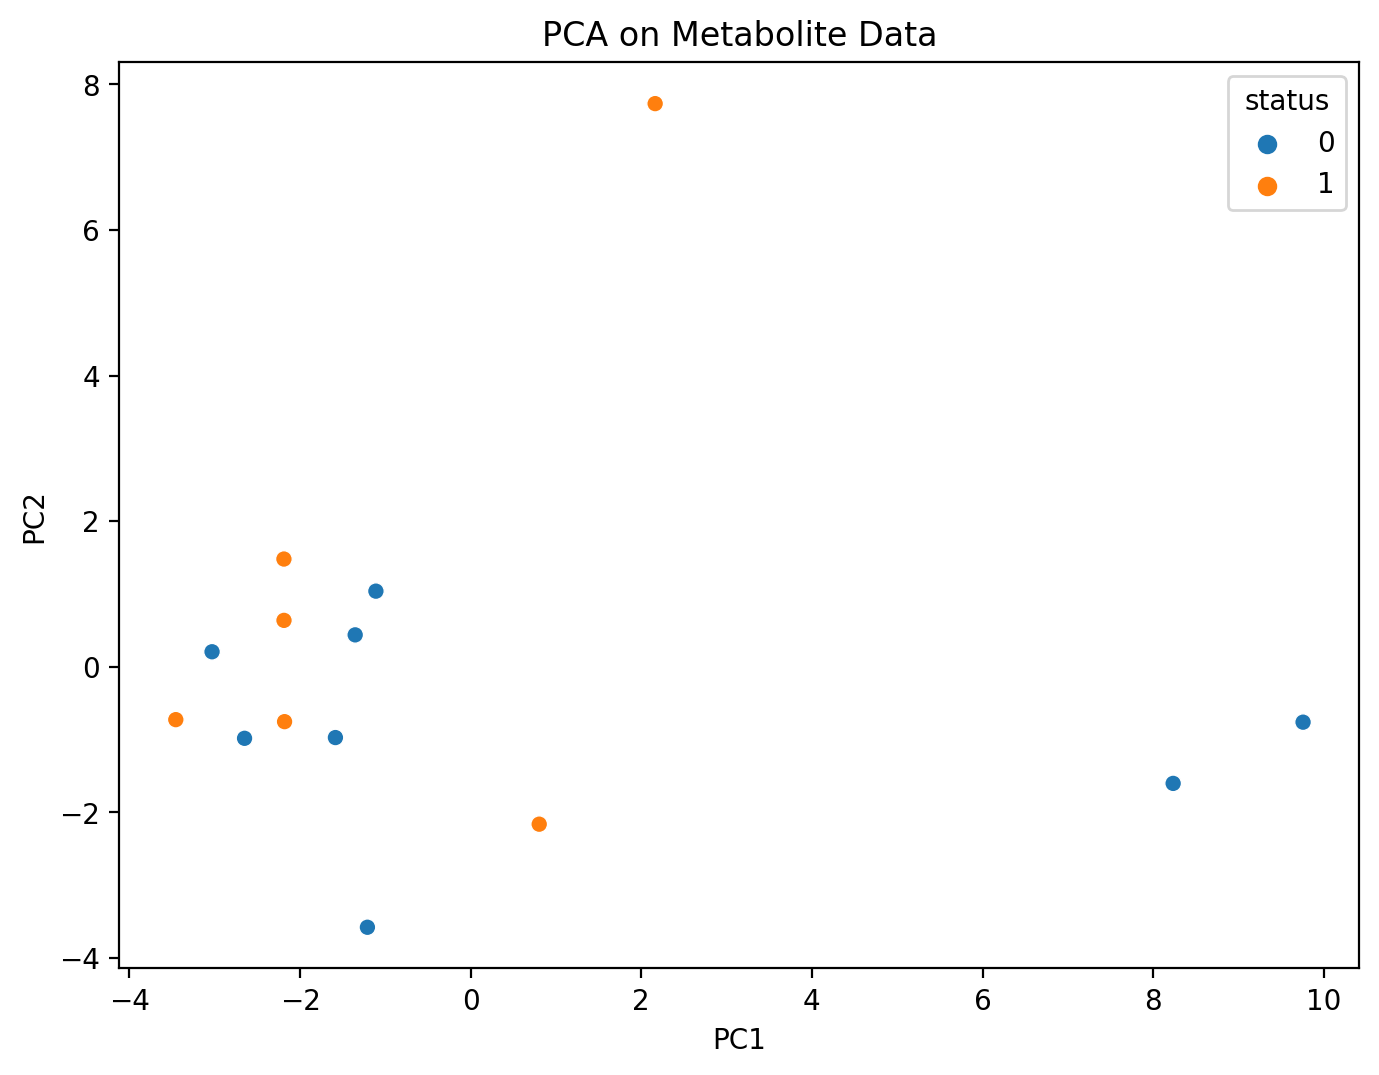

In [146]:
import seaborn as sns
# Perform PCA
pca = PCA(n_components=2)  # Specify the number of components you want to keep
X_pca = pca.fit_transform(x)

# Convert to DataFrame for convenience
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['status'] = y

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='status', data=df_pca)
plt.title('PCA on Metabolite Data')
plt.show()

In [73]:
from sklearn.cross_decomposition import PLSRegression
# Perform PLS-DA
plsda = PLSRegression(n_components=2)  # Specify the number of components (can be adjusted)
plsda.fit(x_train, y_train)  # Fit the PLS-DA model on the training data

# Predict the classes for the test data
y_pred = plsda.predict(x_test)

# Evaluate the model
y_pred_class = [1 if pred >= 0.5 else 0 for pred in y_pred]  # Convert predicted probabilities to class labels

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.50      0.17      0.25         3
weighted avg       1.00      0.33      0.50         3



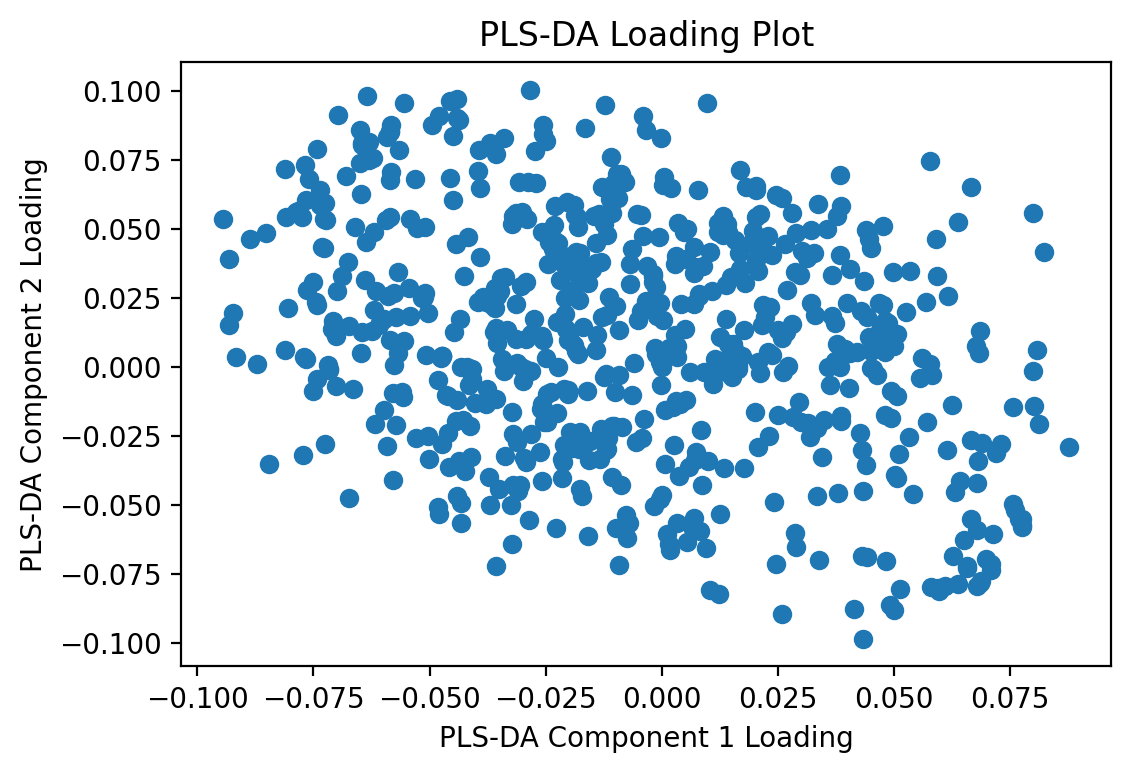

In [76]:
loadings = plsda.x_loadings_

# Plot the loadings
plt.scatter(loadings[:, 0], loadings[:, 1])
plt.xlabel('PLS-DA Component 1 Loading')
plt.ylabel('PLS-DA Component 2 Loading')
plt.title('PLS-DA Loading Plot')
plt.show()

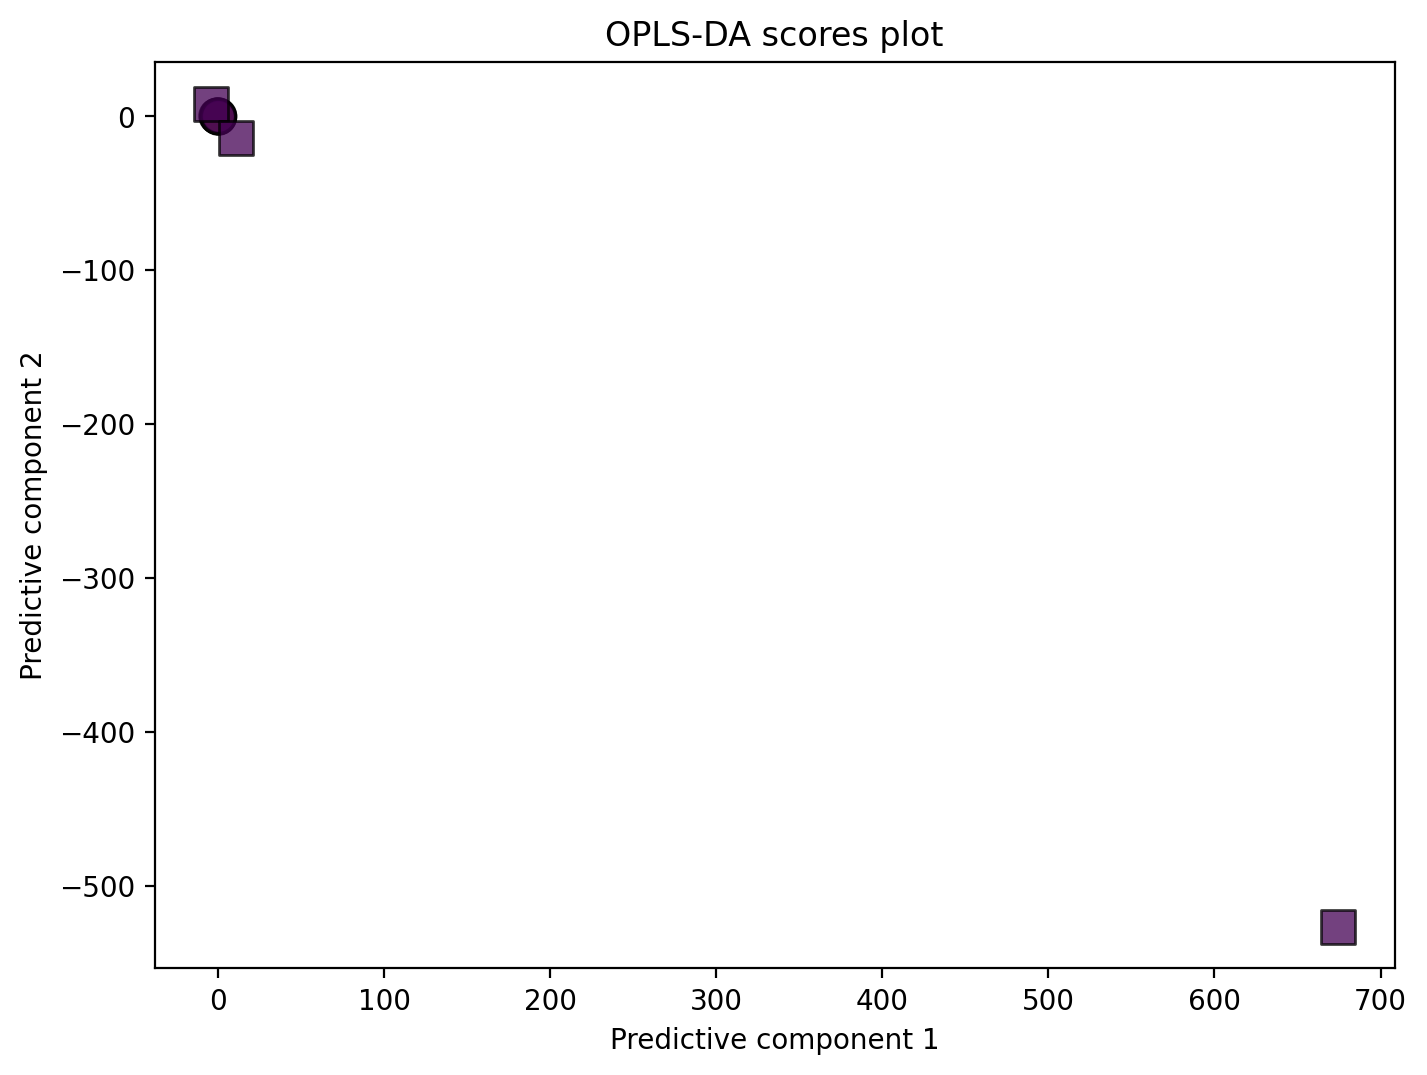

In [115]:
from pyopls import OPLS
# Perform OPLS-DA
opls = OPLS(2)  # use two predictive components
Z_train = opls.fit_transform(x_train, y_train)
Z_test = opls.transform(x_test)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, edgecolors='k', alpha=0.75, s=150, cmap='viridis')
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test, edgecolors='k', alpha=0.75, s=150, cmap='viridis', marker='s')
plt.xlabel('Predictive component 1')
plt.ylabel('Predictive component 2')
plt.title('OPLS-DA scores plot')
plt.show()

### Base GB for classfication 

In [47]:
# Set up the Gradient Boosting classifier
model = GradientBoostingClassifier(random_state=42)

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.83
Permutation test p-value: 0.0594


### Fine-Tune Model(GB)

In [48]:
# Set up the Gradient Boosting classifier
model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5],  
    'learning_rate': [0.1, 0.01, 0.001]  
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

KeyboardInterrupt: 

In [ ]:
# Save the model to disk
filename = 'models/gb_model_acc.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Base RF for classificaiton

In [ ]:
# Set up the Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.87
Permutation test p-value: 0.0198


### Fine-Tune for model(RF)

In [ ]:
# Set up the Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# # Save the model to disk
# filename = 'models/finalized_rf_model_1.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)
Best Score: 0.87
Best Parameters:
{'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### Fine-Tune for model(RF)

In [ ]:
# Set up the Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# # Save the model to disk
# filename = 'models/finalized_rf_model_1.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
RandomForestClassifier(max_depth=2, max_features='auto', n_estimators=50,
                       random_state=42)
Best Score: 0.87
Best Parameters:
{'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# Save the model to disk
filename = 'models/rf_model_acc.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Base SVM for classificaiton

In [ ]:
# Set up the SVM classifier
model = SVC()

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.57
Permutation test p-value: 0.4851


### Fine-Tune Model(SVM)

In [ ]:
# Set up the SVC classifier
model = SVC()

# Define the parameter grid
param_grid = {
    'C': [1, 10, 100],  # Example values for C
    'kernel': ['linear', 'rbf'],  # Example values for kernel
    'gamma': [0.1, 1, 10],  # Example values for gamma
    'degree': [2, 3, 4],  # Example values for degree
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
SVC(C=1, degree=2, gamma=0.1)
Best Score: 0.57
Best Parameters:
{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
# Save the model to disk
filename = 'models/svm_model_acc.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Based XGB for classification

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.70
Permutation test p-value: 0.1287


### Fine-Tune model(XGB)

In [ ]:
# Set up the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'min_child_weight':[1, 2, 3, 4, 5], 
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
    'max_depth':[1, 2, 3, 4, 5, None], 
    'n_estimators':[2, 25, 50, 75, 100]
    }

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# Save the model to disk
# filename = 'models/finalized_xgb_model.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Best Score: 0.70
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 2, 'subsample': 0.9}


In [ ]:
# Save the model to disk
filename = 'models/xgb_model_acc.sav'
pickle.dump(best_model, open(filename, 'wb'))

### Base XGB for classificaiton

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform permutation test
score, permutation_scores, pvalue = permutation_test_score(
    model, x, y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print(f"Model score: {score:.2f}")
print(f"Permutation test p-value: {pvalue:.4f}")

Model score: 0.70
Permutation test p-value: 0.1287


In [ ]:
# Set up the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'min_child_weight':[1, 2, 3, 4, 5], 
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
    'max_depth':[1, 2, 3, 4, 5, None], 
    'n_estimators':[2, 25, 50, 75, 100]
    }

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# Save the model to disk
# filename = 'models/finalized_xgb_model.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Best Score: 0.70
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 2, 'subsample': 0.9}


### Base RF for classificaiton

In [ ]:
# Set up the Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}

# Set up StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=1)
grid_search.fit(x, y)

# Retrieve the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# # Save the model to disk
# filename = 'models/finalized_rf_model_1.sav'
# pickle.dump(best_model, open(filename, 'wb'))

print("Best Model:")
print(best_model)
print(f"Best Score: {best_score:.2f}")
print("Best Parameters:")
print(best_params)

Best Model:
RandomForestClassifier(max_depth=2, max_features='auto', n_estimators=50,
                       random_state=42)
Best Score: 0.87
Best Parameters:
{'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### SHAP

In [308]:
# Shap
# Load the model from disk
model = xgb.XGBClassifier()
# Train the model on your data
model.fit(x, y)

# Create a SHAP explainer object
explainer = shap.Explainer(model, x)

# Calculate the SHAP values for all the features
shap_values = explainer(x)

# Create a new figure before generating the summary plot
plt.figure()

# Create a summary plot of the SHAP values
shap.summary_plot(shap_values, x, max_display=10, plot_type='bar',show=False)

# Save the figure
#plt.savefig('figures/shap_summary_auto_bar.png', bbox_inches='tight', dpi=300)

# Now display the plot
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:L-Iditol, L(-)-Carnitine, L-Isoleucine, L-Kynurenine, Creatinine, Betaine, 3-Methylhistidine, 5-Hydroxyindole-3-acetic acid, Acetyl-L-carnitine, trans-3-Indoleacrylic acid, D-(+)-Proline, N-Ethylglycine, DL-Stachydrine, Choline, L-(+)-Lactic acid, L-Homocitrulline, MFCD03547962, Creatine, DL-Arginine, L-(-)-Methionine, L-Histidine, 3-Methylsulfolene, L-Valine, D-(+)-Glucose, Leucine, D-(+)-Tryptophan, lenticin, DL-Glutamine, L-Lysine, L-Tyrosine, Bilirubin, L-Anserine, N-Methylglutamate, Uric acid, L-(+)-Citrulline, 2-Methylthiazolidine, L-alpha-Glycerylphosphorylcholine, pyroglutamine, L-Pyroglutamic acid, Erucamide, L(-)-Pipecolinic acid, Metformin, Piperine, L-Glutamic acid, D-(-)-Glutamine, 1-Aminocyclohexanecarboxylic acid, p-Cresylsulfate, 2-Aminoisobutyric Acid, L-Aspartic acid, Isocaffeine, Taurine, L-Threonine, 4-Hydroxybutyric acid (GHB), LysoPC(20:5(5Z,8Z,11Z,14Z,17Z)), L-Cysteine-S-sulfate, (Hydroxyethyl)methacrylate, Homocitrulline, D-, RG1300000, 2,5-Dimethyl-4-pyrimidinamine, Ornithine, Decanoylcarnitine, Lactamide, Methyl indole-3-acetate, 4-Phenolsulfonic acid, Propionylcarnitine, 4-Oxoproline, 2-Aminoadipic acid, CMPF, Trigonelline, 4-Hydroxybenzoic acid, 5,6-dimethyl-4-oxo-4H-pyran-2-carboxylic acid, (S)-(+)-2-Amino-1-propanol, Tributyl citrate, 6-Methylnicotinamide, L-Cystine, Acetylcholine, Acetyl-β-methylcholine, N(alpha)-methyl-L-lysine, N-Methyl-2-pyrrolidone, Methyl acetoacetate, MFCD00020424, Allopurinol, 5955761, Paraxanthine, N6,N6,N6-Trimethyl-L-lysine, Methyl-3-aminobenzoate, DL-Carnitine, Prolinamide, DL-Alanine, D-Asparagine, 5-Nitro-o-toluidine, 2-Amino-4-methylpyrimidine, Testosterone sulfate, N-methyl-4-pyridone-3-carboxamide, 3-Hydroxybutyric acid, D-(+)-Pyroglutamic Acid, 2-(1-Methyl-1H-pyrrol-2-yl)-3-(3,4,5-trimethoxyphenyl)acrylonitrile, 4138517, N-Benzylformamide, DL-Malic acid, Etoricoxib, 1,3,7-trimethyl-2,3,6,7-tetrahydro-1H-purine-2,6-dione, 3-Indoxyl sulphate, D-(+)-Malic acid, paracetamol sulfate, L-Allothreonine, N-Phenylacetylglutamine, Glycoursodeoxycholic acid, Nadolol, ACPC, L-Citrulline, Asparagine, Docosahexaenoic acid ethyl ester, Homo-L-arginine, 5-Chloro-4-fluoro-2-nitroaniline, (E)-3,4,5-Trimethoxycinnamic acid, N3,N4-Dimethyl-L-arginine, Guvacoline, Cotinine, phenyl ?-D-glucopyranoside, Succinic acid, 5946880, DJ2981225, Vigabatrin, PPG n4, 1-(1Z-hexadecenyl)-sn-glycero-3-phosphocholine, OPEO, Leucylproline, Dodecyl sulfate, 3-Hydroxy-L-proline, Pyruvic acid, Glycocholic acid, Buprenorphine, 4147610, 2-Hydroxyhippuric acid, 4-Dodecylbenzenesulfonic acid, Phenacetin, N-(3,12-Dihydroxy-24-oxocholan-24-yl)glycine, Inosine, (3alpha,5beta)-17-Oxoandrostan-3-yl hydrogen sulfate, Decamethylcyclopentasiloxane, Fexofenadine, Acetaminophen glucuronide, 1-heptadecanoyl-sn-glycero-3-phosphocholine, N(6),N(6)-Dimethyl-L-lysine, Caprolactam, Levulinic acid, L-Phenylalanine, Theobromine, D-(+)-Pipecolinic acid, D-Serine, MFCD22416941, Fumaric acid, Threonine, Heptanophenone, 4-Vinylcyclohexene, Palmitoylcarnitine, 4-tert-Butylcyclohexyl acetate, N-Acetylleucylleucine, Methyl 5-oxo-D-prolinate, DL-Dipalmitoylphosphatidylcholine, (E,E)-2,4-Dodecadienal, Glycochenodeoxycholic acid, 1,1,6-Trimethyl-1,2-dihydronaphthalene, Hexanoylcarnitine, L-Ergothioneine, 5-Tetradecynoic acid, PPG n5, Salicylic acid, Ethyl sulfate, L-Serine, Hippuric acid, trans-3-Hydroxycotinine, 1-(4,5-dihydro-1H-imidazol-2-yl)-3,5-dimethyl-1H-pyrazole hydrobromide, Pantothenic acid, Tris(2-butoxyethyl) phosphate, α-Cyano-4-hydroxycinnamic acid, L(+)-2-Aminobutyric acid, NP-015114, 2,3-DIHYDROXY-4-METHOXYBENZOIC ACID, (−)-nabilone, Gln-Glu, Linoleyl carnitine, Pipecolamide, Pseudouridine, β-D-Glucopyranuronic acid, NP-008993, 5,6-Dihydro-4H-1,3-oxazin-2-amine, Pregabalin, Phenyl phosphate, Taurochenodeoxycholic acid, Uridine, 7-Methylguanine, NP-008442, 2,2,6,6-Tetramethyl-4-piperidinol, 5-Henicosyl-1,3-benzenediol, Cholic acid, 5-Aminolevulinic acid, (2R)-2,3-Dihydroxypropanoic acid, Atenolol, 1,5-Naphthalenediamine, MFCD00055592, RG5927903, Androst-5-ene-3,17-diol, hydrogen sulfate, (3beta,17beta)-, 3197885, 4-Hydroxyisoleucine, 4-Amino-3-hydroxybenzoic acid, Stiripentol, 2-(1H-indol-3-yl)acetic acid, Benzaldehyde, L-Theanine, 4-Pyridoxic acid, Furazolidone, Xanthine, Prolylglycine, Laurolactam, Perfluoro-1-octanesulfonic acid (PFOS), Hexadecanamide, D-Erythro-sphingosine 1-phosphate, hexamethylcyclotrisiloxane, Nicotinamide 1-oxide, Medronic Acid, Ethanoic anhydride, ADB-FUBINACA, Oleamide, Genistein 4'-O-glucuronide, epiandrosterone sulfate, DL-Lactic Acid, Pulegone, L-Anserine (beta-alanyl-N-methylhistidine) (nitrate salt), Methylimidazoleacetic acid, 3-Piperidinone, Pantothenate, Citric acid, UNII:67GL43KSFC, Pyridoxine, 235BBF3K97, Aliskiren, Famotidine, Gluconic acid, 3-Ureidopropionic acid, Nicotinamide, Propylparaben, (2S)-2-Amino-3-hydroxy-4-methylpentanoic acid, Guanine, Uracil, 4149853, NP-020454, gamma-Glutamylleucine, 12-Aminododecanoic acid, (2S,3R,4E)-2-(Dodecanoylamino)-3-hydroxy-4-octadecen-1-yl 2-(trimethylammonio)ethyl phosphate, Isocitric acid, L-Methionine sulfoxide, Stearamide, N-Acetylornithine, 3-Hydroxyvaleric acid, ionene, QL1400000, Stearoyl-L-carnitine, 1-oleoyl-sn-glycero-3-phosphoethanolamine, Dihydrothymine, 2-Oxobutyric acid, 3-(4-benzylpiperazino)pyrazine-2-carbonitrile, 2-Hydroxy glutaric acid, 1-Methylnicotinamide, Guanidinosuccinic acid, LU3453000, Quinoline, Muscimol, 15-Hexadecynoic acid, Theophylline, 3-Hydroxypyridine, DL-β-Leucine, Succinic semialdehyde, 2-Hydroxy-5-vinylphenyl hydrogen sulfate, Guanosine, Ethyl 4-(2-hydroxy-2-propanyl)-2-propyl-1H-imidazole-5-carboxylate, L-Ascorbic acid 2-sulfate, Indole-3-lactic acid, 3-(3-methylthio)propylmalic acid, Isophorone, Deoxycholic Acid, Asp-Ile, (+/-)-2-Hydroxyglutaric acid, Glycerophospho-N-palmitoyl ethanolamine, Picrocrocin, N-Methylhistamine, N8-Acetylspermidine, Carvone, PEG n5, DL-α-Aminocaprylic acid, (+/-)9-HpODE, p-cymene, Dehydroacetic acid, 4-Picoline, 10-HDA, L-Cysteinylglycine disulfide, morpholine-4-carboximidamide hydrobromide, NP-011220, Isopropylparaben, 1-pentadecanoyl-sn-glycero-3-phosphocholine, 4-oxododecanedioic acid, 1-(1Z-octadecenyl)-2-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-sn-glycero-3-phosphocholine, 3,4-Dihydroxyphenylpropionic acid, 1,2,3,4-Tetramethyl-1,3-cyclopentadiene, 3,5-di-tert-Butyl-4-hydroxybenzaldehyde, N,N'-Dicyclohexylurea, metominostrobin, Hostmaniane, alpha-Ketoglutaric acid, 3-Methylxanthine, 4-Indolecarbaldehyde, Benzenesulfonic acid, Jasmone, N1-(6-methyl-4-oxo-3,4-dihydroquinazolin-2-yl)-4-nitrobenzamide, Maleamic acid, 7-Isopropyl-4a-methyl-1-methylene-1,2,3,4,4a,9,10,10a-octahydrophenanthrene, 2-Butylfuran, N-Me-Leu-OH, Isocyclemone E, NP-012972, Arabic acid, (4S,5S,8S,10R)-4,5,8-trihydroxy-10-methyl-3,4,5,8,9,10-hexahydro-2H-oxecin-2-one, 2-Oxoglutaric acid, Cyclohexylamine, sedoheptulosan, L-(-)-3-Phenyllactic acid, 4-(7-Hydroxy-4-oxo-4H-chromen-3-yl)phenyl hydrogen sulfate, 3-(3,4,5-trimethoxyphenyl)propanoic acid, Mesaconic acid, N-Arachidonoyl-L-serine, Gentisic acid, 2-Amino-1,3,4-octadecanetriol, LT9970000, n-Amylbenzene, 2-Oxindole, Prolylleucine, Glycine, NP-020414, N-Acetyl-L-carnosine, p-Xylene, Aspartame, YQ3683000, α-Aspartylphenylalanine, Hexylbenzene, Phenol, (10E,12Z)-10,12-Hexadecadienal, Octyl hydrogen phthalate, Cortisol, 1,3-Cyclohexanedicarboxylic acid, Metamfepramone, Fasoracetam, Apigenin 7-sulfate, 10-Hydroxydecanoic acid, Homovanillic acid sulfate, 12(13)Ep-9-KODE, 6-Aminonicotinic acid, 4-Methylcyclohexanamine, .alpha.-Aminoadipic acid, Crotonic acid, 9-(2,3-Dihydroxypropoxy)-9-oxononanoic acid, 2-Arachidonoyl glycerol, MFCD00025468, Celiprolol, N-(5-acetamidopentyl)acetamide, Eicosapentaenoic acid methyl ester, Acetohydroxamic acid, (2S)-eriodictoyl-7-O-beta-D-glucopyranosiduronic acid, Phenmetrazine, 2,3-Dihydroxy-2-methylbutanoic acid, Ferulic acid 4-sulfate, 3-Hydroxydecanoic acid, 9-Methyluric acid, Dodecamethylcyclohexasiloxane, LysoPC(P-18:0), N6-Me-Adenosine, NP-019547, N-Ethylleucinamide, Acetanilide, PLK, MFCD00014603, 4-O-(A-D-MANNOPYRANOSYL)-D-MANNOSE, N6-Acetyl-L-lysine, Perfluorooctanoic acid (PFOA), (3β,5ξ,9ξ)-3,23-Dihydroxy-1-oxoolean-12-en-28-oic acid, Glutaric acid, (±)9-HpODE, Asarone, Azelaic acid, Methyprylon, Methylsuccinic acid, Docosahexaenoic Acid, 6-Hydroxycaproic acid, Glycolic acid, β-Muricholic acid, α-Pyrrolidinopropiophenone, Lauryldimethylamine oxide, Naproxen, Trolox, (2Z)-2-Formyl-3-phenyl-2-propen-1-yl hydrogen sulfate, 1-(beta-D-ribofuranosyl)thymine, 2-(Methylsulfonyl)-3-(pyrazin-2-ylamino)acrylonitrile, Dehydro-L-ascorbic acid, 1-Vinyl-2-pyrrolidone, 2-Naphthalenesulfonic acid, 3-Anisic acid, Phomalone, N-propargylglycine, MFCD00037215, 1-(2-chlorobenzyl)-2,4-dioxo-1,2,3,4-tetrahydropyrimidine-5-carbonitrile, 1,7-Dimethyluric acid, PEG n6, Orotidine, Malonic acid, 16-Hydroxyhexadecanoic acid, Pregnane-3,3-diol, O-malonyl-L-carnitine, Perfluoro-1-hexanesulfonic acid (PFHxS), L-Glutaminyl-L-Threonine, 5-Aminovaleric acid, Ethyl 4-(carboxymethyl)-2-ethoxybenzoate, MFCD00871363, 6-Deoxy-2-O-(4-deoxy-beta-L-threo-hex-4-enopyranuronosyl)-beta-L-mannopyranose, 2-Furoylglycine, 1-(1H-Indol-5-yl)ethanone, DH1924980, NP-001346, NP-018661, 3-Methoxyphenylacetic acid, 2-(acetylamino)-4-(methylthio)butanoic acid, 5α-Dihydrotestosterone glucuronide, Glycyl-L-leucine, Ecgonine methyl ester, Dipropylene glycol dimethyl ether, 2-Naphthylamine, (2R,3S,4S,5R)-2-(6-hydroxy-2-imino-3,7-dihydropurin-9-yl)-5-(hydroxymethyl)tetrahydrofuran-3,4-diol, 9-Chlorohexadecafluoro-3-oxanonane-1-sulfonate, Adipic acid, Docosanamide, Asp-Gly, 2-(4-Nonylphenoxy)ethanol, Jasmonic acid, L-monomethylarginine, AJ4900000, Suberic acid, Itaconic acid, Brassylic acid, 4-Hydroxy-5-(phenyl)-valeric acid-O-sulphate, N,N-Bis(2-hydroxyethyl)dodecanamide, PPG n6, 4-Hydroxy-3-(sulfooxy)benzoic acid, N-Formylmethionine, Oxymorphone, 2-guanidinoethanol, Butylparaben, Cantharidin, Istamycin C1, Gln-Gln, Norepinephrine, ?-Muricholic Acid, Cortisone, 2-Carboxyphenyl alpha-D-glucopyranosiduronic acid, lys-gln, Pentachlorophenol, 5,5-Dimethyl-4-(3-oxobutyl)dihydro-2(3H)-furanone, Oleic acid, 2-Acetamido-N-β-aspartyl-2-deoxyhexopyranosylamine, Asp-Gln, 5-Methylcytosine, 4-Hydroxypropranolol, Dibenzylamine, 1,3,7-Trimethyluric acid, Aceturic acid, (7alpha,25R)-7-Hydroxy-3-oxocholest-4-en-26-oic acid, Dodecanedioic acid, 2-Acetamidooctanoic acid, 3',4'-Dimethoxyacetophenone, Indole, 5'-S-Methyl-5'-thioadenosine, NP-011548, Hesperetin, 3-tert-Butyladipic acid, Pimelic acid, 3-Chloro-N'-(pyridin-3-ylcarbonyl)benzohydrazide, 4-oxo-4-(4-toluidino)but-2-enoic acid, 12-Hydroxydodecanoic acid, N2-Dimethylguanosine, 2-Aminoindan-2-carboxylic acid, 2,3-Dimethoxy-5-methyl-6-(3-methyl-2-buten-1-yl)-1,4-benzenediol, Trp-Phe, N-Acetylvaline, 4-(allyloxy)-1,2-dihydroquinolin-2-one, Dinoterb, PEG n7, Docosahexaenoic acid methyl ester, 13(S)-HOTrE, NP-021023, NP-008952, NP-021797, Glu-Gly, 6,7-Dimethyl-8-ribityllumazine, (20R)-17-Hydroxy-3-oxopregn-4-en-20-yl hydrogen sulfate, Nicotinuric acid, NP-007909, N'1,N'3-di(4-isopropylbenzylidene)-2-butylpropanediohydrazide, 4-(pentyloxy)benzene-1-carbohydrazide, Terephthalic acid, 5-Methylnorleucine, Traumatic Acid, Leu-Val, 6-Methylindole, Thymine, 3',4'-Dihydroxyphenylacetone, NP-001596, NP-007966, NP-021038, 4-Methylphenol, Tetradecanedioic acid, Tetrahydrocortisone, Ecgonine, Arecoline, (2E)-3-(3,4-Dimethoxyphenyl)acrylic acid, 1-(2,5-Dihydroxyphenyl)-3-hydroxy-1-butanone, Daminozide, 3,5-Dihydroxy-4-methoxybenzoic acid, RH3422500, actarit, (Methylthio)pyrazine, 3-Methylsalicylic acid, Calocarpin, Glu-Arg, Levothyroxine, Ethylmalonic acid, Perfluoro-1-heptanesulfonate, tert-Butyl 3-amino-1-methyl-2,3-dioxopropylcarbamate, (4S)-4-Amino-5-hydroxypentanoic acid, Pencolide, methyl 2-(2-acetyl-4,5-dimethoxyphenyl)acetate, AMPA, 2-(acetylamino)-3-(1H-indol-3-yl)propanoic acid, (2S,3R)-4-Methylene-2-octyl-5-oxotetrahydro-3-furancarboxylic acid, NP-003145, (+/-)9,10-dihydroxy-12Z-octadecenoic acid, 7-Methylguanosine, NP-018716, Medroxyprogesterone 17-acetate, NP-002676, Nevirapine, Fipronil sulfone, N-Acetyl-D-galactosamine 4-sulfate, NP-012551, 2-Hydroxy-1,2-diphenylethyl hydrogen sulfate, 3-Methyl-2-(3-oxo-1,2-benzothiazol-2(3H)-yl)pentanoic acid, Bufexamac, (2E)-2-Isopropyl-2-butenedioic acid, N-Acetylneuraminic acid, Primobolan, 4-tert-Octylphenol monoethoxylate, MEDICA 16, N-Acetyl-DL-norvaline, Tetraacetylethylenediamine, TI0889000, α-Cyano-3-hydroxycinnamic acid, methyl 3,5-ditert-butyl-4-hydroxybenzoate, Dinoseb, AM9627000, N,N-Dimethyldecylamine N-oxide, Aceglutamide

In [306]:
# Get a list of all column names
column_names = x.columns

# Create a new list for column names that do not contain '[', ']' or '<'
new_columns = [col for col in column_names if '[' not in col and ']' not in col and '<' not in col]

# Select only the columns in the new list
x = x[new_columns]

In [272]:
shap.summary_plot(shap_values, features, plot_type="bar", max_display=x.shape[1])

NameError: name 'features' is not defined

In [307]:
x = x.astype('Int64')

TypeError: cannot safely cast non-equivalent object to int64